### Overview

"Airbnb for Boston with fraud detcetion" data was downloaded from Kaggle with the following link:

https://www.kaggle.com/datasets/hawkingcr/airbnb-for-boston-with-fraud-detection/download?datasetVersionNumber=1

The downloaded file is saved as "output.csv" under data directory.

In [7]:
import os

data_dir = "./data"
data_file = "output.csv"
if os.path.exists(data_dir) == False:
    os.mkdir(data_dir)
data_file_path = os.path.join(data_dir,data_file)
print(data_file_path)

./data/output.csv


In [8]:
import pandas as pd

df = pd.read_csv(data_file_path)
#print(df.head())
#print(df.shape)
print(df.info())
#print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   host_response_rate         3585 non-null   int64  
 1   host_identity_verified     3585 non-null   int64  
 2   host_total_listings_count  3585 non-null   int64  
 3   city                       3585 non-null   int64  
 4   is_location_exact          3585 non-null   int64  
 5   property_type              3585 non-null   int64  
 6   room_type                  3585 non-null   int64  
 7   accommodates               3585 non-null   int64  
 8   bathrooms                  3585 non-null   float64
 9   bedrooms                   3585 non-null   float64
 10  beds                       3585 non-null   float64
 11  bed_type                   3585 non-null   int64  
 12  amenities                  3585 non-null   int64  
 13  price                      3585 non-null   int64

### Correlation

To find out the influence of features on column "fraud", print out the correlation map.

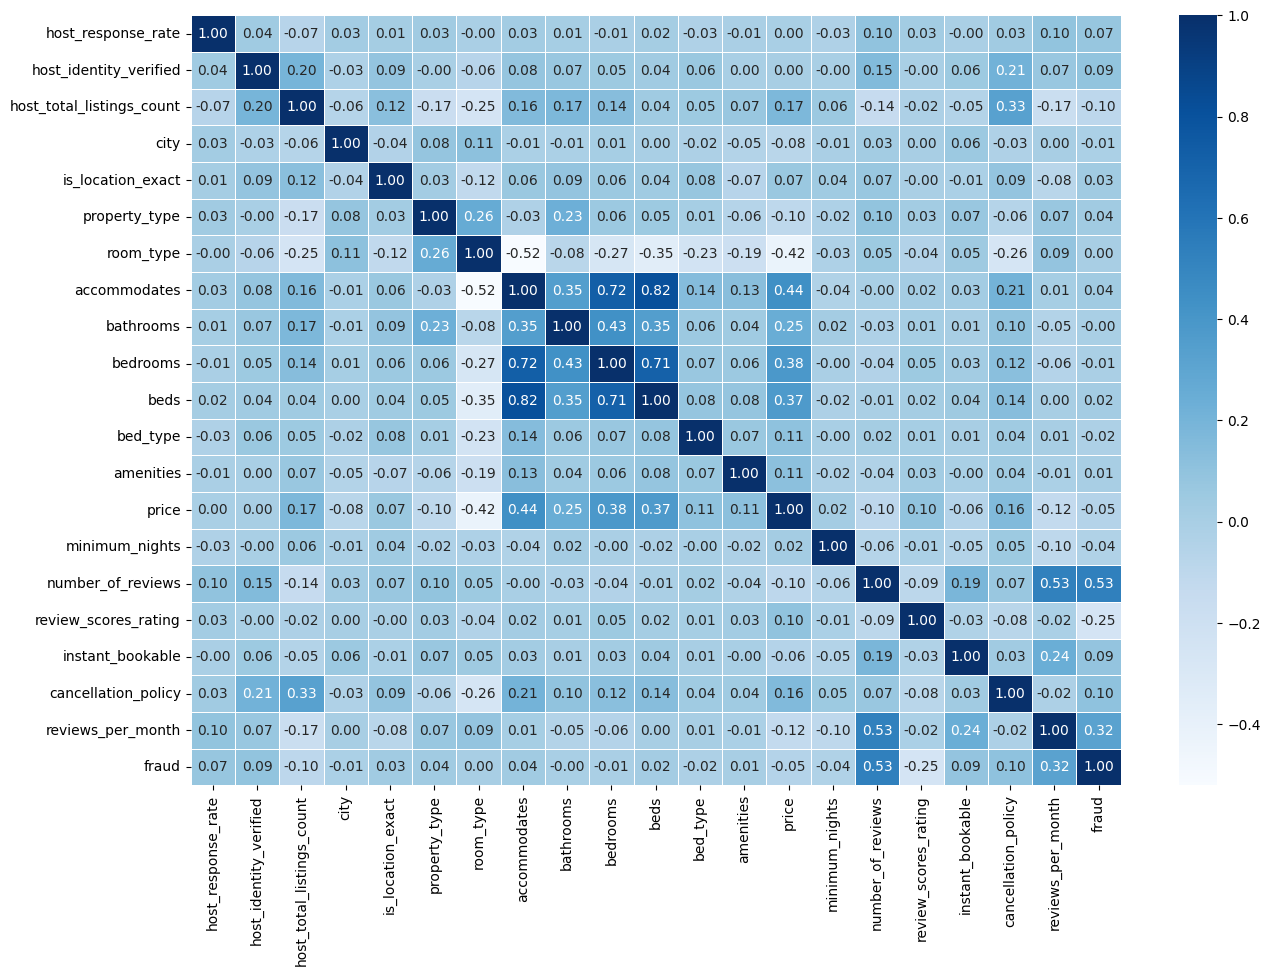

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='Blues', linewidths=0.5, fmt='.2f')
plt.show()

### Cleanup

Drop features with correlation value < 0.03 against "fraud".

In [10]:
df1 = df.copy()
corr_matrix = df1.corr()
for cl in df1.columns:
    if (cl == 'fraud'):
        continue
    if abs(corr_matrix['fraud'][cl]) < 0.03:
        print('to drop: ',cl)
        df1.drop([cl],axis=1,inplace=True)

to drop:  city
to drop:  room_type
to drop:  bathrooms
to drop:  bedrooms
to drop:  beds
to drop:  bed_type
to drop:  amenities


Show updated correlation map with remaining features.

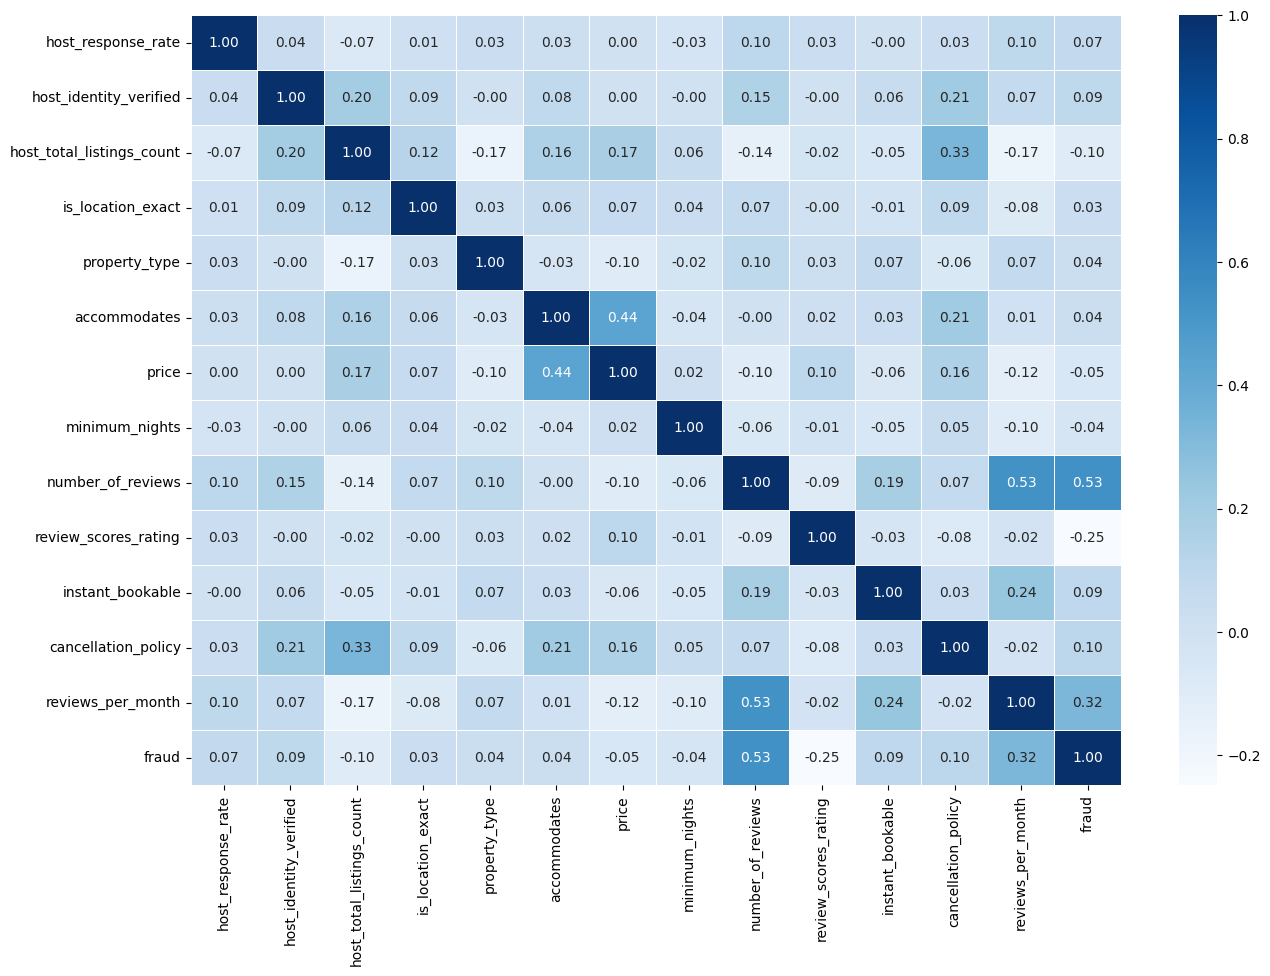

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(df1.corr(), annot=True, cmap='Blues', linewidths=0.5, fmt='.2f')
plt.show()

Check if there is any missing value.

In [13]:
missing_values = df1.isnull().sum()
#duplicated  = df.duplicated().sum()
#datatypes  = df.dtypes
#unqiue = df.nunique()

columns  = pd.DataFrame({
    "missing_values":missing_values,
    #"duplicated":duplicated,
    #"datatypes":datatypes,
    #"unqiue":unqiue,
})

columns

,missing_values
host_response_rate,0
host_identity_verified,0
host_total_listings_count,0
is_location_exact,0
property_type,0
accommodates,0
price,0
minimum_nights,0
number_of_reviews,0
review_scores_rating,0


### Split data

Split data into training and test data sets

In [16]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df1, test_size=0.25,random_state=42)

#df_train.describe()
#df_test.describe()
print("train data count: ",df_train.count())
print("test data count: ",df_test.count())


train data count:  host_response_rate           2688
host_identity_verified       2688
host_total_listings_count    2688
is_location_exact            2688
property_type                2688
accommodates                 2688
price                        2688
minimum_nights               2688
number_of_reviews            2688
review_scores_rating         2688
instant_bookable             2688
cancellation_policy          2688
reviews_per_month            2688
fraud                        2688
dtype: int64
test data count:  host_response_rate           897
host_identity_verified       897
host_total_listings_count    897
is_location_exact            897
property_type                897
accommodates                 897
price                        897
minimum_nights               897
number_of_reviews            897
review_scores_rating         897
instant_bookable             897
cancellation_policy          897
reviews_per_month            897
fraud                        897
dtype: int64

### Upsample

Check data balance for training target column.

In [19]:

X_train = df_train.drop('fraud',axis=1)
Y_train = df_train['fraud']

print(Y_train.value_counts())


0    2120
1     568
Name: fraud, dtype: int64


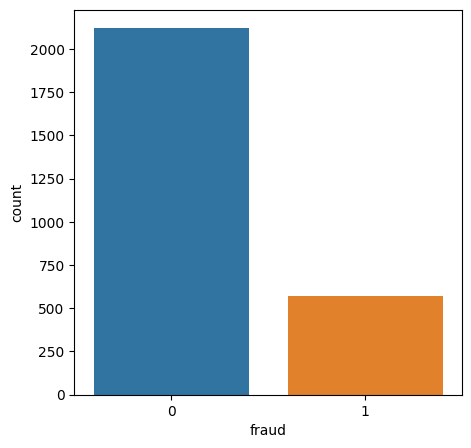

In [20]:
plt.figure(figsize=(5,5))
sns.countplot(x=Y_train)
plt.show()

Upsample training to balance data.

In [21]:
from sklearn.utils import resample

df_majority = df_train[(df_train['fraud'] == 0)]
df_minority = df_train[(df_train['fraud'] == 1)]

#upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 2120, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])
print(df_upsampled['fraud'].value_counts())

1    2120
0    2120
Name: fraud, dtype: int64


Save upsampled training data and test data

In [23]:
train_data_path = "./data/train.csv"
test_data_path = "./data/test.csv"

df_upsampled.to_csv(train_data_path,index=False)
df_test.to_csv(test_data_path,index=False)

Double check saved data

In [24]:
train_pd = pd.read_csv(train_data_path)
train_pd.describe()

,host_response_rate,host_identity_verified,host_total_listings_count,is_location_exact,property_type,accommodates,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,fraud
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000
mean,96.435142,0.757547,47.142689,0.866745,1.969340,3.132547,16882.783019,2.748821,33.176415,92.383255,0.187264,1.269811,2.257462,0.500000
std,9.647162,0.428617,147.566621,0.339890,3.380209,1.838329,12662.073358,6.845263,48.840797,8.876339,0.390169,0.849258,2.208211,0.500059
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1100.000000,1.000000,0.000000,20.000000,0.000000,0.000000,0.020000,0.000000
25%,98.000000,1.000000,1.000000,1.000000,0.000000,2.000000,8500.000000,1.000000,2.750000,89.000000,0.000000,1.000000,0.870000,0.000000
50%,100.000000,1.000000,2.000000,1.000000,0.000000,2.000000,14300.000000,2.000000,14.000000,95.000000,0.000000,1.000000,1.400000,0.500000
75%,100.000000,1.000000,7.000000,1.000000,4.000000,4.000000,21900.000000,3.000000,42.000000,100.000000,0.000000,2.000000,3.120000,1.000000
max,100.000000,1.000000,749.000000,1.000000,12.000000,16.000000,300000.000000,300.000000,404.000000,100.000000,1.000000,3.000000,16.300000,1.000000


In [25]:
test_pd = pd.read_csv(test_data_path)
test_pd.describe()

,host_response_rate,host_identity_verified,host_total_listings_count,is_location_exact,property_type,accommodates,price,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month,fraud
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000
mean,94.767001,0.724638,63.006689,0.866221,1.809365,2.938685,17488.740245,3.149387,18.859532,93.739130,0.162765,1.202899,1.662085,0.221851
std,14.248054,0.446946,180.957498,0.340605,3.303881,1.731286,17775.431237,5.644211,34.480428,9.251023,0.369357,0.871852,1.858172,0.415723
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1000.000000,1.000000,0.000000,20.000000,0.000000,0.000000,0.010000,0.000000
25%,98.000000,0.000000,1.000000,1.000000,0.000000,2.000000,8500.000000,1.000000,1.000000,91.000000,0.000000,0.000000,0.560000,0.000000
50%,100.000000,1.000000,2.000000,1.000000,0.000000,2.000000,14900.000000,2.000000,5.000000,97.000000,0.000000,1.000000,1.000000,0.000000
75%,100.000000,1.000000,7.000000,1.000000,1.000000,4.000000,21900.000000,3.000000,21.000000,100.000000,0.000000,2.000000,2.000000,0.000000
max,100.000000,1.000000,749.000000,1.000000,12.000000,16.000000,400000.000000,90.000000,281.000000,100.000000,1.000000,3.000000,19.150000,1.000000
